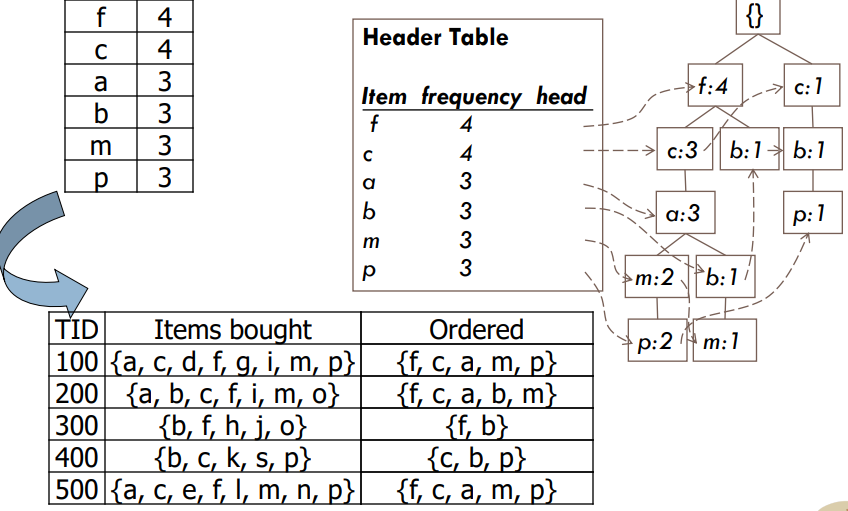

In [15]:
from collections import defaultdict
from itertools import chain, combinations

# Node

In [16]:
class Node:
    def __init__(self, itemName, frequency, parentNode):
        self.itemName = itemName
        self.count = frequency
        self.parent = parentNode
        self.children = {}
        self.next = None

    def increment(self, frequency):
        self.count += frequency

    def display(self, ind=1):
        print('  ' * ind, self.itemName, ' ', self.count)
        for child in list(self.children.values()):
            child.display(ind+1)

In [17]:
def getFrequencyFromList(itemSetList):
    frequency = [1 for i in range(len(itemSetList))]
    return frequency

* Count frequency and create header table
* Delete the items below minSup
* HeaderTable column [Item: [frequency, headNode]]
* Init Null head node
* Update FP tree for each cleaned and sorted itemSet
* Traverse from root to leaf, update tree with given item

In [18]:
def constructTree(itemSetList, frequency, minSup):
    headerTable = defaultdict(int)

    for idx, itemSet in enumerate(itemSetList):
        for item in itemSet:
            headerTable[item] += frequency[idx]

    headerTable = dict((item, sup) for item, sup in headerTable.items() if sup >= minSup)
    if(len(headerTable) == 0):
        return None, None

    for item in headerTable:
        headerTable[item] = [headerTable[item], None]

    fpTree = Node('Null', 1, None)

    for idx, itemSet in enumerate(itemSetList):
        itemSet = [item for item in itemSet if item in headerTable]
        itemSet.sort(key=lambda item: headerTable[item][0], reverse=True)

        currentNode = fpTree
        for item in itemSet:
            currentNode = updateTree(item, currentNode, headerTable, frequency[idx])

    return fpTree, headerTable

In [19]:
def updateHeaderTable(item, targetNode, headerTable):
    if(headerTable[item][1] == None):
        headerTable[item][1] = targetNode
    else:
        currentNode = headerTable[item][1]
        # Traverse to the last node then link it to the target
        while currentNode.next != None:
            currentNode = currentNode.next
        currentNode.next = targetNode


In [20]:
def updateTree(item, treeNode, headerTable, frequency):
    if item in treeNode.children:
        # If the item already exists, increment the count
        treeNode.children[item].increment(frequency)
    else:
        # Create a new branch
        newItemNode = Node(item, frequency, treeNode)
        treeNode.children[item] = newItemNode
        # Link the new branch to header table
        updateHeaderTable(item, newItemNode, headerTable)

    return treeNode.children[item]


In [27]:
def ascendFPtree(node, prefixPath):
    if node.parent != None:
        prefixPath.append(node.itemName)
        ascendFPtree(node.parent, prefixPath)

In [28]:
def findPrefixPath(basePat, headerTable):
    # First node in linked list
    treeNode = headerTable[basePat][1] 
    condPats = []
    frequency = []
    while treeNode != None:
        prefixPath = []
        # From leaf node all the way to root
        ascendFPtree(treeNode, prefixPath)  
        if len(prefixPath) > 1:
            # Storing the prefix path and it's corresponding count
            condPats.append(prefixPath[1:])
            frequency.append(treeNode.count)

        # Go to next node
        treeNode = treeNode.next  
    return condPats, frequency

* Sort the items with frequency and create a list.
* Start with the lowest frequency.
* Pattern growth is achieved by the concatenation of suffix pattern with frequent patterns generated from conditional FP-tree.
* Find all prefix path, constrcut conditional pattern base.
* Construct conditonal FP Tree with conditional pattern base
* Mining recursively on the tree

In [29]:
def mineTree(headerTable, minSup, preFix, freqItemList):
    sortedItemList = [item[0] for item in sorted(list(headerTable.items()), key=lambda p:p[1][0])]
    for item in sortedItemList:  
        newFreqSet = preFix.copy()
        newFreqSet.add(item)
        freqItemList.append(newFreqSet)
        conditionalPattBase, frequency = findPrefixPath(item, headerTable)
        conditionalTree, newHeaderTable = constructTree(conditionalPattBase, frequency, minSup)
        if newHeaderTable != None:
            mineTree(newHeaderTable, minSup,
                       newFreqSet, freqItemList)


# Support

In [23]:
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

def getSupport(testSet, itemSetList):
    count = 0
    for itemSet in itemSetList:
        if(set(testSet).issubset(itemSet)):
            count += 1
    return count

# Confidence

In [24]:
def associationRule(freqItemSet, itemSetList, minConf):
    rules = []
    for itemSet in freqItemSet:
        subsets = powerset(itemSet)
        itemSetSup = getSupport(itemSet, itemSetList)
        for s in subsets:
            confidence = float(itemSetSup / getSupport(s, itemSetList))
            if(confidence > minConf):
                rules.append([set(s), set(itemSet.difference(s)), confidence])
    return rules

In [25]:
def fpgrowth(itemSetList, minSupRatio, minConf):
    frequency = getFrequencyFromList(itemSetList)
    minSup = len(itemSetList) * minSupRatio
    fpTree, headerTable = constructTree(itemSetList, frequency, minSup)
    if(fpTree == None):
        print('No frequent item set')
    else:
        freqItems = []
        mineTree(headerTable, minSup, set(), freqItems)
        rules = associationRule(freqItems, itemSetList, minConf)
        return freqItems, rules

In [33]:
itemSetList = [['eggs', 'bacon', 'bread'],
                ['eggs', 'bacon', 'apple'],
                ['soup', 'bacon', 'banana']]
freqItemSet, rules = fpgrowth(itemSetList, minSupRatio=0.5, minConf=0.5)
print(freqItemSet)
print(rules)  

[{'eggs'}, {'eggs', 'bacon'}, {'bacon'}]
[[{'eggs'}, {'bacon'}, 1.0], [{'bacon'}, {'eggs'}, 0.6666666666666666]]
